In [30]:
import matplotlib.pyplot as plt
import pyrosetta as pr
import numpy as np
import pandas as pd
from rotamer_library import load_rotamor_library, all_atom_coordinates_from_restype, restype_1to3 
from mapping_aas import map_pyrosetta_atom_names, get_res_map_martini, map_pyrosetta_martini_names
from formfactor import cSAXSparameters, calculate_distogram, getAAFormFactor_fast, poly6d_fixed
import tqdm
import matplotlib.cm as cm
import os 
import argparse
import csv

pr.init()

libpath = '/Users/isabelvinterbladh/Documents/Github/saxs-python/dunbrack-rotamer/original'
db = load_rotamor_library(libpath)

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.conda.m1.cxx11thread.serialization.python311.Release 2024.42+release.3366cf78a3df04339d1982e94531b77b098ddb99 2024-10-11T08:24:04] retrieved from: http://www.pyrosetta.org
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.conda.m1.cxx11thread.serialization.pyth

In [2]:
np.random.seed(0)
np.eye(3)==0


array([[False,  True,  True],
       [ True, False,  True],
       [ True,  True, False]])


 > Calculating bead form factor for ALA ...
core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 985 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.450064 seconds.


1369it [00:00, 30924.52it/s]

Number of rotamers found in Dunbrack lib: 1369
[' N  ', ' CA ', ' C  ', ' O  ', ' OXT', ' CB ', '1H  ', '2H  ', '3H  ', ' HA ', '1HB ', '2HB ', '3HB '] ALA
functools.partial(<function poly6d_fixed.<locals>.poly_func at 0x1073358a0>, coeffs=array([ 46.48701176,   0.        , -37.58685699,   1.68882898,
        19.66411739,  -9.35215638,   1.28037354]))



 > Calculating bead form factor for ARG ...


41106it [00:02, 15579.91it/s]


KeyboardInterrupt: 

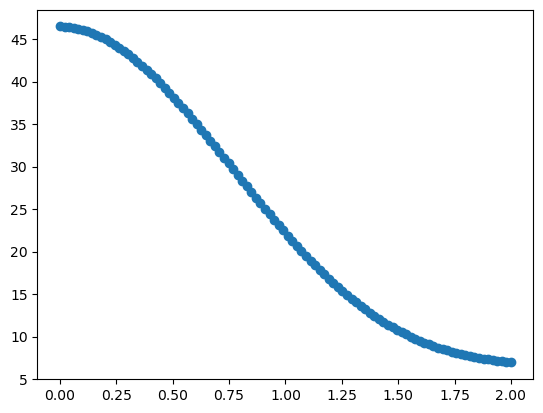

In [6]:
%run formfactor.py
db = load_rotamor_library(libpath)

def getAll_FF(qvals, atom_names_mapped_non_hydrogen, all_coordinates_non_hydrogen):
    saxs_params = cSAXSparameters()
    FF = np.array([saxs_params.computeFormFactors(atom_names_mapped_non_hydrogen, q) for q in qvals]).T
    #for atoms in all_coordinates_non_hydrogen:
     #   all_rotamers = []
     #   for i, _q in enumerate(qvals):
            
    amino_FF = saxs_params.getAAFormFactor(qvals, FF, atom_names_mapped_non_hydrogen, all_coordinates_non_hydrogen) 
    return amino_FF #np.array(total, dtype=complex)

with open('poly_coeffs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Restype', 'Coefficient Index', 'Value'])

    for restype in restype_1to3.keys():
        restype3 = restype_1to3[restype]
        print("\n > Calculating bead form factor for %s ..."%restype3)
        
        all_coordinates, atom_names,elements, probs = all_atom_coordinates_from_restype(restype, db)
        n_rotamer = len(all_coordinates)
        print("Number of rotamers found in Dunbrack lib: %i"%n_rotamer)
        print(atom_names, restype3)
        
        atom_names_mapped = map_pyrosetta_atom_names(atom_names, restype3)
        # let's remove the hydrogrens from the coordinates
        non_hydrogen_indices = [i for i, n in enumerate(atom_names_mapped) if n is not None]
        all_coordinates_non_hydrogen = all_coordinates[:,non_hydrogen_indices]
        atom_names_mapped_non_hydrogen = [n for i, n in enumerate(atom_names_mapped) if i in non_hydrogen_indices]
        qfits = np.linspace(0.75, 2, 80)
        qfits = np.insert(qfits, 0, 0.0)
        #print((np.sqrt(np.sum((coords[..., None, :] - coords[..., None, :, :]) ** 2, axis=-1))[...,None]*qfits))
        
        
        total = getAll_FF(qfits, atom_names_mapped_non_hydrogen, all_coordinates_non_hydrogen)
        #print(total.shape)
        
        V = np.sum((total)*probs[...,None], axis=0)
        #F0 = getAll_FF([0.0], atom_names_mapped_non_hydrogen, all_coordinates_non_hydrogen)
        #qfits = np.insert(qfits, 0, 0.0)
        #V = np.insert(V, 0, np.sum(F0))
        
        poly_coeffs = poly6d_fixed(qfits, V)
        
        print(poly_coeffs)
        qtest = np.linspace(0.0, 2.0, 100)
        plt.plot(qtest, poly_coeffs(x=qtest), 'o')
        
    
        # Save poly_coeffs to a CSV file
        coeffs = poly_coeffs.keywords['coeffs']
        for i, coeff in enumerate(coeffs):
                writer.writerow([restype3, i, coeff])
    
    


In [42]:
%run formfactor.py
restype3 = restype_1to3['A']
restype = 'A'
print("\n > Calculating bead form factor for %s ..."%restype3)
        
all_coordinates, atom_names,elements, probs = all_atom_coordinates_from_restype(restype, db)
n_rotamer = len(all_coordinates)
print("Number of rotamers found in Dunbrack lib: %i"%n_rotamer)
print(atom_names, restype3)
        
atom_names_mapped = map_pyrosetta_atom_names(atom_names, restype3)
        # let's remove the hydrogrens from the coordinates
non_hydrogen_indices = [i for i, n in enumerate(atom_names_mapped) if n is not None]
all_coordinates_non_hydrogen = all_coordinates[:,non_hydrogen_indices]
atom_names_mapped_non_hydrogen = [n for i, n in enumerate(atom_names_mapped) if i in non_hydrogen_indices]
#qfits = np.linspace(0.75, 2, 80)
#qfits = np.insert(qfits, 0, 0.0)
#print((np.sqrt(np.sum((coords[..., None, :] - coords[..., None, :, :]) ** 2, axis=-1))[...,None]*qfits))
qfits = np.array([0,0.1])       
        
total = getAll_FF(qfits, atom_names_mapped_non_hydrogen, all_coordinates_non_hydrogen[:1])
print(total.shape)
        
        
V = np.sum((total)*probs[...,None][:1], axis=0)


 > Calculating bead form factor for ALA ...


1369it [00:00, 23591.19it/s]


Number of rotamers found in Dunbrack lib: 1369
[' N  ', ' CA ', ' C  ', ' O  ', ' OXT', ' CB ', '1H  ', '2H  ', '3H  ', ' HA ', '1HB ', '2HB ', '3HB '] ALA
(1, 6, 6)
FF: (6, 6, 2) (6, 6, 2) atomffs: (6, 2)
Factors: (6, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

dq (6, 6, 2) (1, 2)
(6, 6, 2) (6, 2)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [13]:
V

array([46.486294  , 46.12250042])